<a href="https://colab.research.google.com/github/mralamdari/Computer-Vision-Projects/blob/main/Car_Plate_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import os
import glob
import matplotlib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from sklearn import model_selection

tf.__version__

'2.11.0'

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'
!kaggle datasets download -d andrewmvd/car-plate-detection
!unzip \*.zip && rm *.zip

In [3]:
os.makedirs('/content/data/', exist_ok=True)
os.replace('/content/images', '/content/data/images')
os.replace('/content/annotations', '/content/data/annotations')

In [4]:
IMAGE_PATH = '/content/data/images/'
ANNOTATION_PATH =  '/content/data/annotations/'

In [76]:
def xml_to_yolo(path, img_path):
  Y = []
  X = []
  for xml_file in glob.glob(path+'*.xml'):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    img_name = img_path + xml_file.replace(path, '')[:-4]+'.png'

    h, w, d = plt.imread(img_name).shape

    img = tf.keras.preprocessing.image.load_img(img_name, target_size=(320, 320))
    img_arr = tf.keras.preprocessing.image.img_to_array(img) / 255.0

    X.append(img_arr)

    for children in root.findall('object'):
      bndbox = children[5]
      xmin = float(bndbox[0].text) / w
      ymin = float(bndbox[1].text) / h
      xmax = float(bndbox[2].text) / w
      ymax = float(bndbox[3].text) / h
      
      Y.append([xmin, xmax, ymin, ymax])

  return X, Y

In [ ]:
x, y = xml_to_yolo(ANNOTATION_PATH, IMAGE_PATH)

In [ ]:
vgg16 = tf.keras.applications.VGG16()

In [ ]:
vgg16.compile(optimizer='adam',
              loss='categorical',
              metrics=['metrics'])

In [ ]:
train_x, test_x, train_y, test_y = model_selection.train_test_split(X, y)

#ddd

In [ ]:
num_imgs = 50000

img_size = 16
min_rect_size = 3
max_rect_size = 8
num_objects = 2

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))
shapes = np.zeros((num_imgs, num_objects, 1))

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        if np.random.choice([True, False]):
            width, height = np.random.randint(min_rect_size, max_rect_size, size=2)
            x = np.random.randint(0, img_size - width)
            y = np.random.randint(0, img_size - height)
            imgs[i_img, x:x+width, y:y+height] = 1.
            bboxes[i_img, i_object] = [x, y, width, height]
            shapes[i_img, i_object] = [0]
        else:
            size = np.random.randint(min_rect_size, max_rect_size)
            x, y = np.random.randint(0, img_size - size, size=2)
            mask = np.tril_indices(size)
            imgs[i_img, x + mask[0], y + mask[1]] = 1.
            bboxes[i_img, i_object] = [x, y, size, size]
            shapes[i_img, i_object] = [1]
            
imgs.shape, bboxes.shape

((50000, 16, 16), (50000, 2, 4))

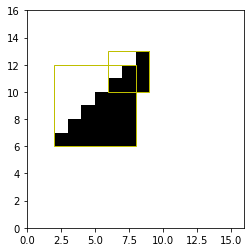

In [ ]:
i = 0
# TODO: Why does the array have to be transposed?
plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
for bbox, shape in zip(bboxes[i], shapes[i]):
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r' if shape[0] == 0 else 'y', fc='none'))


In [ ]:
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

y = np.concatenate([bboxes / img_size, shapes], axis=-1).reshape(num_imgs, -1)
y.shape

i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]


In [ ]:

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(256, input_dim=X.shape[-1], activation='relu'), 
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(y.shape[-1])
    ])

model.compile(omptimizer='adadelta',
              loss='mse',
              metrics=['accuracy'])

In [ ]:

# Flip bboxes during training.
# Note: The validation loss is always quite big here because we don't flip the bounding boxes for the validation data. 
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]  # TODO: Check if its more performant if tensor elements are accessed directly below.
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

In [ ]:
def dist(bbox1, bbox2):
    return np.sqrt(np.sum(np.square(bbox1[:2] - bbox2[:2])))

In [ ]:
num_epochs_flipping = 5
num_epochs_no_flipping = 0  # has no significant effect
flipped_train_y = np.array(train_y)
flipped = np.zeros((len(flipped_train_y), num_epochs_flipping + num_epochs_no_flipping))
ious_epoch = np.zeros((len(flipped_train_y), num_epochs_flipping + num_epochs_no_flipping))
dists_epoch = np.zeros((len(flipped_train_y), num_epochs_flipping + num_epochs_no_flipping))
mses_epoch = np.zeros((len(flipped_train_y), num_epochs_flipping + num_epochs_no_flipping))

# TODO: Calculate ious directly for all samples (using slices of the array pred_y for x, y, w, h).
for epoch in range(num_epochs_flipping):
    print ('Epoch', epoch)
    model.fit(train_X, flipped_train_y, epochs=1, validation_data=(test_X, test_y), verbose=2)
    pred_y = model.predict(train_X)

    for sample, (pred, exp) in enumerate(zip(pred_y, flipped_train_y)):
        
        # TODO: Make this simpler.
        pred = pred.reshape(num_objects, -1)
        exp = exp.reshape(num_objects, -1)
        
        pred_bboxes = pred[:, :4]
        exp_bboxes = exp[:, :4]
        
        # TODO: Try flipping array and see if results differ.
        ious = np.zeros((num_objects, num_objects))
        dists = np.zeros((num_objects, num_objects))
        mses = np.zeros((num_objects, num_objects))
        for i, exp_bbox in enumerate(exp_bboxes):
            for j, pred_bbox in enumerate(pred_bboxes):
                ious[i, j] = IOU(exp_bbox, pred_bbox)
                dists[i, j] = dist(exp_bbox, pred_bbox)
                mses[i, j] = np.mean(np.square(exp_bbox - pred_bbox))
                
        new_order = np.zeros(num_objects, dtype=int)
        
        for i in range(num_objects):
            # Find pred and exp bbox with maximum iou and assign them to each other (i.e. switch the positions of the exp bboxes in y).
            ind_exp_bbox, ind_pred_bbox = np.unravel_index(mses.argmin(), mses.shape)
            ious_epoch[sample, epoch] += ious[ind_exp_bbox, ind_pred_bbox]
            dists_epoch[sample, epoch] += dists[ind_exp_bbox, ind_pred_bbox]
            mses_epoch[sample, epoch] += mses[ind_exp_bbox, ind_pred_bbox]
            mses[ind_exp_bbox] = 1000000#-1  # set iou of assigned bboxes to -1, so they don't get assigned again
            mses[:, ind_pred_bbox] = 10000000#-1
            new_order[ind_pred_bbox] = ind_exp_bbox
        
        flipped_train_y[sample] = exp[new_order].flatten()
        
        flipped[sample, epoch] = 1. - np.mean(new_order == np.arange(num_objects, dtype=int))#np.array_equal(new_order, np.arange(num_objects, dtype=int))  # TODO: Change this to reflect the number of flips.
        ious_epoch[sample, epoch] /= num_objects
        dists_epoch[sample, epoch] /= num_objects
        mses_epoch[sample, epoch] /= num_objects
        
            
    print ('Flipped {} % of all elements'.format(np.mean(flipped[:, epoch]) * 100.))
    print ('Mean IOU: {}'.format(np.mean(ious_epoch[:, epoch])))
    print ('Mean dist: {}'.format(np.mean(dists_epoch[:, epoch])))
    print ('Mean mse: {}'.format(np.mean(mses_epoch[:, epoch])))
    
# print '------------------------------------'
# print 'Training now without flipping bboxes'
# print '------------------------------------'
    
# for epoch in range(num_epochs_flipping, num_epochs_flipping + num_epochs_no_flipping):
#     print 'Epoch', epoch
#     model.fit(train_X, flipped_train_y, nb_epoch=1, validation_data=(test_X, test_y), verbose=2)
#     pred_y = model.predict(train_X)

#     # Calculate iou/dist, but don't flip.
#     for sample, (pred_bboxes, exp_bboxes) in enumerate(zip(pred_y, flipped_train_y)):
        
#         pred_bboxes = pred_bboxes.reshape(num_objects, -1)
#         exp_bboxes = exp_bboxes.reshape(num_objects, -1)        
        
#         for exp_bbox, pred_bbox in zip(exp_bboxes, pred_bboxes):
#             ious_epoch[sample, epoch] += IOU(exp_bbox, pred_bbox)
#             dists_epoch[sample, epoch] += dist(exp_bbox, pred_bbox)
#             mses_epoch[sample, epoch] += np.mean(np.square(exp_bbox - pred_bbox))
            
#         ious_epoch[sample, epoch] /= num_objects
#         dists_epoch[sample, epoch] /= num_objects 
#         mses_epoch[sample, epoch] /= num_objects 
            
# #     print 'Flipped {} % of all elements'.format(np.mean(flipped[:, epoch]) * 100.)
#     print 'Mean IOU: {}'.format(np.mean(ious_epoch[:, epoch]))
#     print 'Mean dist: {}'.format(np.mean(dists_epoch[:, epoch]))
#     print 'Mean mse: {}'.format(np.mean(mses_epoch[:, epoch]))
#     print
    
# TODO: Calculate IOU and dist for validation data during training.

Epoch 0
1250/1250 - 5s - loss: 1.2512 - val_loss: 0.6032 - 5s/epoch - 4ms/step
1250/1250 [==============================] - 2s 2ms/step
Flipped 49.769999999999996 % of all elements
Mean IOU: 0.007859193352009687
Mean dist: 0.8797448999706355
Mean mse: 0.51864670046129
Epoch 1
1250/1250 - 5s - loss: 1.0567 - val_loss: 0.4950 - 5s/epoch - 4ms/step
1250/1250 [==============================] - 3s 2ms/step
Flipped 8.434999999999999 % of all elements
Mean IOU: 0.01126615508267084
Mean dist: 0.7987428326355115
Mean mse: 0.41814962263317496
Epoch 2
1250/1250 - 7s - loss: 0.9446 - val_loss: 0.4278 - 7s/epoch - 6ms/step
1250/1250 [==============================] - 8s 7ms/step
Flipped 6.08 % of all elements
Mean IOU: 0.014347690264117656
Mean dist: 0.7398230211061122
Mean mse: 0.3565922847082358
Epoch 3
1250/1250 - 8s - loss: 0.8574 - val_loss: 0.3808 - 8s/epoch - 6ms/step
1250/1250 [==============================] - 5s 4ms/step
Flipped 4.625 % of all elements
Mean IOU: 0.017053951856157455
Mean 

Text(0, 0.5, 'Training sample')

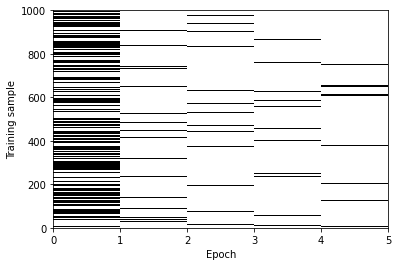

In [ ]:
plt.pcolor(flipped[:1000], cmap='Greys', vmax=1.)
# plt.axvline(num_epochs_flipping, c='r')
plt.xlabel('Epoch')
plt.ylabel('Training sample')

(0.0, 1.0)

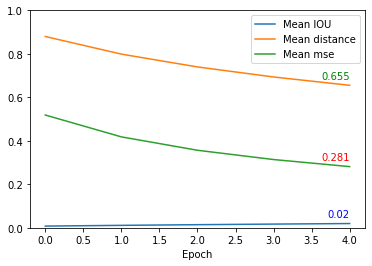

In [ ]:
mean_ious_epoch = np.mean(ious_epoch, axis=0)
mean_dists_epoch = np.mean(dists_epoch, axis=0)
mean_mses_epoch = np.mean(mses_epoch, axis=0)
plt.plot(mean_ious_epoch, label='Mean IOU')  # between predicted and assigned true bboxes
plt.plot(mean_dists_epoch, label='Mean distance')  # relative to image size
plt.plot(mean_mses_epoch, label='Mean mse')  # relative to image size
plt.annotate(np.round(np.max(mean_ious_epoch), 3), (len(mean_ious_epoch)-1, mean_ious_epoch[-1]+0.03), horizontalalignment='right', color='b')
plt.annotate(np.round(np.min(mean_dists_epoch), 3), (len(mean_dists_epoch)-1, mean_dists_epoch[-1]+0.03), horizontalalignment='right', color='g')
plt.annotate(np.round(np.min(mean_mses_epoch), 3), (len(mean_mses_epoch)-1, mean_mses_epoch[-1]+0.03), horizontalalignment='right', color='r')
# plt.axvline(num_epochs_flipping, c='r')
plt.xlabel('Epoch')
plt.legend()
plt.ylim(0, 1)

# plt.savefig('plots/bw-multiple-rectangles-mse.png', dpi=300)

In [ ]:
pred_y = model.predict(test_X)
pred_y = pred_y.reshape(len(pred_y), num_objects, -1)
pred_bboxes = pred_y[..., :4] * img_size
pred_shapes = pred_y[..., 4:5]
pred_bboxes.shape, pred_shapes.shape

313/313 [==============================] - 1s 2ms/step


((10000, 2, 4), (10000, 2, 1))

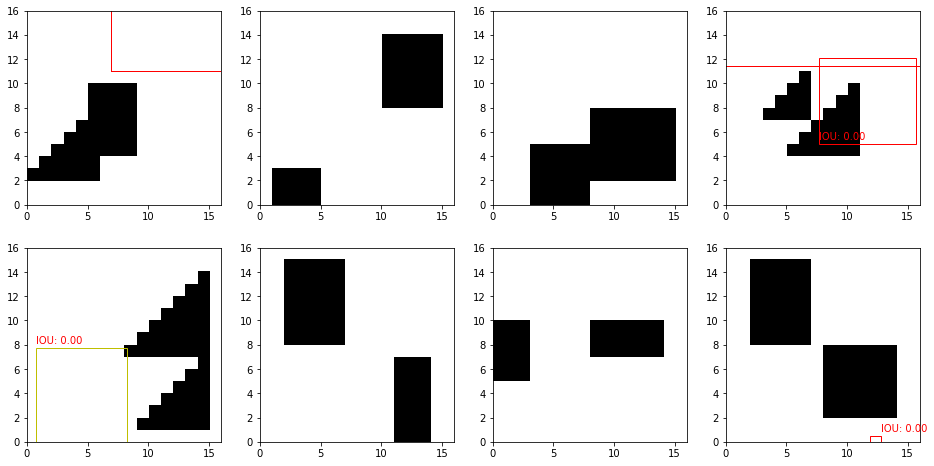

In [ ]:
plt.figure(figsize=(16, 8))
for i_subplot in range(1, 9):
    plt.subplot(2, 4, i_subplot)
    i = np.random.randint(len(test_X))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox, pred_shape in zip(pred_bboxes[i], test_bboxes[i], pred_shapes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r' if pred_shape[0] <= 0.5 else 'y', fc='none'))
        # TODO: Calculate max IOU with all expected bounding boxes.
        plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.4), color='r')
